<a href="https://colab.research.google.com/github/vinpala/Deep_Inspirations/blob/master/inspiration_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inspirational quotes Generator

In [2]:
!pip install fastai==1.0.34

    100% |████████████████████████████████| 143kB 12.6MB/s 
    100% |████████████████████████████████| 61kB 23.7MB/s 
    100% |████████████████████████████████| 1.9MB 14.7MB/s 
    100% |████████████████████████████████| 23.3MB 1.3MB/s 
spacy 2.0.16 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: thinc 6.12.1
    Uninstalling thinc-6.12.1:
      Successfully uninstalled thinc-6.12.1
  Found existing installation: spacy 2.0.18
    Uninstalling spacy-2.0.18:
      Successfully uninstalled spacy-2.0.18
  Found existing installation: fastai 1.0.49
    Uninstalling fastai-1.0.49:
      Successfully uninstalled fastai-1.0.49


In [0]:
from fastai import *
from fastai.text import *

In [0]:
import fastai

In [5]:
fastai.__version__ #<= '1.0.34'

'1.0.34'

## Preparing the language model

In [6]:
df = pd.read_csv('Quotes.csv', sep=';')
df.head()

,QUOTE,AUTHOR,GENRE
0,Age is an issue of mind over matter. If you do...,Mark Twain,age
1,"Anyone who stops learning is old, whether at t...",Henry Ford,age
2,Wrinkles should merely indicate where smiles h...,Mark Twain,age
3,True terror is to wake up one morning and disc...,Kurt Vonnegut,age
4,A diplomat is a man who always remembers a wom...,Robert Frost,age


The training data contains 1 tweet per row and has no labels.

In [7]:
# let's look at a single quote
df['QUOTE'][1]

'Anyone who stops learning is old, whether at twenty or eighty. Anyone who keeps learning stays young. The greatest thing in life is to keep your mind young.'

In [8]:
# number of quotes
len(df)

75966

In [0]:
# batch size
bs = 48

In [0]:
# create langugage model using our data 
data_lm = (TextList.from_df(df,Path('/storage/inspiration-generator/'), col=['QUOTE']) 
          #We randomly split and keep 10% (~609 tweets) for validation
           .random_split_by_pct(0.1)
          #We want to do a language model so we label accordingly
           .label_for_lm()
          .databunch(bs=bs))
data_lm.save('tmp_lm')

## Tokenization

The first step of processing we make tweets go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few quotes in a batch.

In [0]:
data_lm = TextLMDataBunch.load(Path('/storage/inspiration-generator/'), 'tmp_lm', bs=bs)

In [12]:
data_lm.show_batch(rows=10)

idx,text
0,xxbos xxmaj family life was wonderful . xxmaj the streets were bleak . xxmaj the playgrounds were bleak . xxmaj but home was always warm . xxmaj my mother and father had a great relationship . i always felt ' safe ' there . xxbos xxmaj the secret source of humor is not joy but sorrow there is no humor in xxmaj heaven . xxbos xxmaj good humor is n't
1,"try to approach him on the level of his moral integrity he starts to talk business . xxbos xxmaj any fool knows that bravado is always a cover - up for insecurity . xxmaj that 's the truth . xxmaj and on that note , i 'll say goodnight . xxmaj god love you . xxbos xxmaj strange questions are the more interesting ones . xxmaj children by and large"
2,", xxmaj champagne costs too much , xxmaj vodka puts my mouth in gear . i hope this refrain , xxmaj will help me explain , xxmaj as a matter of fact , i like beer . xxbos xxmaj the employee is regarded by the employer merely in the light of his value as an operative . xxmaj his productive capacity alone is taken into account . xxbos xxmaj the"
3,"'s also an affirmation of faith in their country . xxbos xxmaj if philosophy is practice , a demand to know the manner in which its history is to be studied is xxunk : a theoretical attitude toward it becomes real only in the living appropriation of its contents from the texts . xxbos i 'm a competitive person and i love the challenge of mastering new things . xxbos"
4,". xxbos xxmaj courage ought to have eyes as well as arms . xxbos xxmaj let me smile with the wise , and feed with the rich . xxbos xxmaj it was either xxmaj voltaire or xxmaj charlie xxmaj xxunk who said , ' xxmaj we are born alone . xxmaj we live alone . xxmaj we die alone . xxmaj and anything in between that can give us the"
5,"a law 's broken , society is guilty rather than the xxunk . xxmaj it is time to restore the xxmaj american precept that each individual is accountable for his actions . xxbos xxmaj enjoy your sweat because hard work does n't guarantee success , but without it you do n't have a chance . xxbos i ran for president in order to be able to try to change xxmaj"
6,"french word like xxunk when there 's a good xxmaj english phrase for it - cold war . xxbos xxmaj to run away from trouble is a form of cowardice and , while it is true that the suicide xxunk death , he does it not for some noble object but to escape some ill . xxbos xxmaj we 're one of the forces that causes actors to fasten seat"
7,", shoot guns , have adventures . xxbos xxmaj with reasonable men , i will reason with humane men i will plead but to tyrants i will give no quarter , nor waste arguments where they will certainly be lost . xxbos xxmaj and i remember leaving my place in xxup l.a. and - my father is a big fight fan - and i said , ' xxmaj dad ,"
8,". xxbos i 'm very at ease , and i like it . i never thought i would be such a family - oriented guy i did n't think that was part of my makeup . xxmaj but somebody said that as you get older you become the person you always should have been , and i feel that 's happening to me . i 'm rather surprised at who"
9,"these worlds became alive until he discovered its true and living name . xxmaj the name was the breath of life and , sooner or later , he invariably found it . xxbos i 'm 36 and if i met a woman of my own age and married her , i 'd also be marrying her former life , her past . xxmaj it might be xxup ok for some"


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

## Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [13]:
# view the most common dictionary terms
data_lm.vocab.itos[:15]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 ',',
 'the',
 'to',
 'and',
 'i',
 'of']

## Train the language model

We're not going to train a model that generates language from scratch. 

Instead, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our inspirational quote generator, but first, we need to fine-tune the pretrained model with quotes. We'll need to adjust a little bit the parameters of our model. 

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [0]:
# drop_mult is a parameter that controls the % of drop-out used
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.30)

In [15]:
# use learning rate finder to identify a good learning rate to use
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


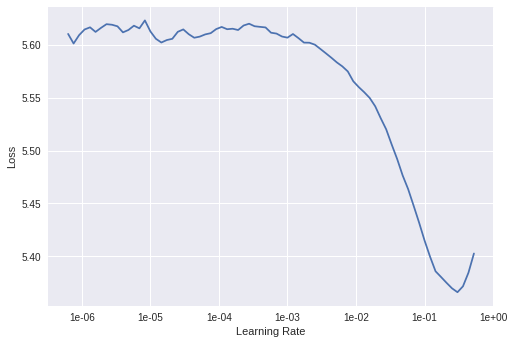

In [16]:
learn.recorder.plot(skip_end=15)

In [17]:
# as a rule of thumb, review the plot above and choose the learning rate with the steepest slope to fit the model
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.210771,4.003152,0.275771
2,4.031643,3.876151,0.288318
3,3.959247,3.844692,0.290186
4,3.870712,3.811392,0.293367
5,3.795509,3.776777,0.296902
6,3.719762,3.750515,0.298656
7,3.647826,3.725406,0.302077
8,3.582844,3.708097,0.303490
9,3.544996,3.697882,0.305185
10,3.508585,3.696165,0.305087


In [0]:
learn.save('quote_head')

In [0]:
learn.load('quote_head');

To complete the fine-tuning, we can then unfeeze and launch a new training to fine-tune all layers of the model.

In [20]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.512639,3.696598,0.305460
2,3.531201,3.694123,0.305626
3,3.512056,3.690317,0.305709
4,3.489574,3.690456,0.305853
5,3.488740,3.689104,0.306075


In [0]:
learn.save('quote_fine_tuned')

In [22]:
learn.load('quote_fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (68370 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /storage/inspiration-generator
x: LMTextList (68370 items)
[Text xxbos xxmaj age is an issue of mind over matter . xxmaj if you do n't mind , it does n't matter ., Text xxbos xxmaj anyone who stops learning is old , whether at twenty or eighty . xxmaj anyone who keeps learning stays young . xxmaj the greatest thing in life is to keep your mind young ., Text xxbos xxmaj wrinkles should merely indicate where smiles have been ., Text xxbos xxmaj true terror is to wake up one morning and discover that your high school class is running the country ., Text xxbos a diplomat is a man who always remembers a woman 's birthday but never remembers her age .]...
Path: /storage/inspiration-generator;

Valid: LabelList
y: LMLabel (7596 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /storage/inspiration-generator
x: LMTextL

##Quote Generation Testing

In [0]:
# adjust below parameters to test inference (generated quotes)

TEXT = "Love is "
N_WORDS = 20
N_SENTENCES = 2

In [27]:
print("\n".join(learn.predict(TEXT, N_WORDS) for _ in range(N_SENTENCES)))

Love is  where she desires truth . she decided not to teach her lacks her purity , but as a friend .
Love is  the best device of touch - of love . xxbos i think while love is there the most virtuous marriage
